# Analysis of Monthly Mean Historical Meteorologic Variables from LOCA and BCSD

This notebook analyzes meteorologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective gridded observations used for training -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Precipitation
- Temperature

In [1]:
from loca import print_date
print_date()

Last executed: 2018-02-04 23:22:51.080384 by jhamman on r8i0n6


# Imports and Options

In [27]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.tools import dask_distributed_setup
from loca.data_catalog import load_monthly_historical_met_datasets

models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
models = ['CCSM4', 'CNRM-CM5']

met_vars = ['pcp', 't_mean']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cluster, client = dask_distributed_setup()
print(cluster) # interact with the cluster object to adjust the size of the computational pool
cluster.scale_up(1)
client

Client Scheduler: tcp://10.148.6.233:50538 Dashboard: http://10.148.6.233:55777/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [23]:
client.restart()

Client Scheduler: tcp://10.148.6.233:50538 Dashboard: http://10.148.6.233:55777/status,Cluster Workers: 90 Cores: 360 Memory: 540.00 GB


# Load Data

In [24]:
hydro_data = load_monthly_historical_met_datasets(models=models, autoclose=True)

# TODO: use 1/8th deg LOCA/Livneh data (waiting on cdo to finish remapping)

load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology


100%|██████████| 2/2 [00:59<00:00, 29.60s/it]


load_monthly_bcsd_meteorology
load_bcsd_dataset


100%|██████████| 2/2 [00:35<00:00, 17.68s/it]

load_monthly_livneh_meteorology
load_daily_livneh_meteorology


load_monthly_maurer_meteorology
load_daily_maurer_meteorology


In [18]:
cluster.scale_up(5)

[3, 4, 5, 6]

In [25]:
epoch = slice('1979-10-01', '1999-09-30')

# TODO: this mean should be weighted by days per month
epoch_means = dict((k, ds.sel(time=epoch).mean('time').persist()) for (k, ds) in hydro_data.items())

tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x2aaadee15dd8>>
Traceback (most recent call last):
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task 'open_dataset-33efb48b931185af3be3759343fad8e1bounds_latitude-1cafc345d3c6026b747269dd50e4c178' memory>
tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x2aaadee15dd8>>
Traceback (most recent call last):
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

KilledWorker: ('open_dataset-5325af266f860fce4a90a3833604f084Prec-e15b2413e3e44b418e44f640f2feeb50', 'tcp://10.148.7.193:53266')

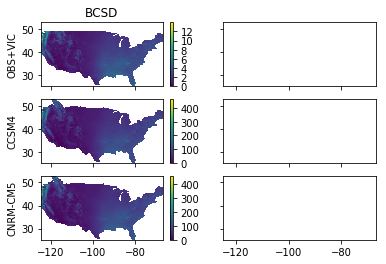

tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x2aaadee15dd8>>
Traceback (most recent call last):
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/distributed/stealing.py", line 305, in balance
    stealable = self.stealable[sat.address][level]
KeyError: 'tcp://10.148.7.162:44400'
tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x2aaadee15dd8>>
Traceback (most recent call last):
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/glade/u/home/jhamman/anaconda/envs/pangeo/lib/python3.6/site-packages/distributed/stealing.py", line 305, in bala

In [28]:
kwargs = {'pcp': {'vmin': 0, 'vmax': None},
          't_mean': {'vmin': 0, 'vmax': 30},}

# TODO: Fix mask issue with LOCA

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=2, nrows=1 + len(models), sharex=True, sharey=True)
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS+VIC')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()     


In [ ]:
diff_kws = {'pcp': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'},
            't_mean': {'vmin': -5, 'vmax': 5, 'cmap': 'RdBu'}}

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2, nrows=1 + len(models), sharex=True, sharey=True)
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS+VIC')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            (ds_data[var] - obs_data[var]).sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()  


In [70]:
# cleanup 
plt.close('all')
cluster.scale_down(5)